- Licensed Materials - Property of IBM
- 5737-M66
- (C) Copyright IBM Corp. 2021, 2022 All Rights Reserved.
- US Government Users Restricted Rights - Use, duplication, or disclosure
- restricted by GSA ADP Schedule Contract with IBM Corp.

# future score sample with IBM methodology 
- This is a sample analysis notebook for how to evolve future score calculation, with IBM methodology. The future health score may from direct input or csv file.
- The core idea is getting the asset data and measurement data from Maximo Health, do the analysis job, and save the analysis result back to Maximo Health.
- This sample notebook works with a configuration file, named `IBM-future-score-from-csv-sample-7.0.0.cfg`
- This sample notebook could be scheduled by the Maximo Health side, to do the daily analysis work.

## Step 1. Install healthlib
- Data Asset is a kind of asset in Watson Studio, you can imagine it as a file repository. 
- As mentioned above, one notebook works with a `<model>.cfg` file, so first step we need to download the `IBM-future-score-from-csv-sample-7.0.0.cfg` from Data Asset to run this substation transformer model.
- Another file is the helper installation package, you can find details of this helper in Step 2.

In [ ]:
from project_lib import Project

project = Project.access()
for f in ['IBM-future-score-from-csv-sample-7.0.0-demo.cfg', 'healthlibv7-1.0.0-cp39-cp39-linux_x86_64.whl']:
    url = project.get_file(f)
    with open(f, 'wb') as f:
        f.write(url.getvalue())
    url.close()

- To make good user experience, we deliver a helper Python library named `healthlib`. The `healthlib` provides useful APIs and functions for the user to interact with Maximo Health side. With `healthlib`, the user could only focus on the analysis work, and not worry about other works (loading data, save result, etc.). First, use Python pip to install healthlib, and then import it into this notebook.
- with Python `help` function, the user could see the functions provided by the `healthlib`.

In [ ]:
##!pip uninstall -y healthlibv7

In [ ]:
!pip install healthlibv7-1.0.0-cp39-cp39-linux_x86_64.whl

In [ ]:
!pip install colorama

In [ ]:
import numpy
from packaging import version
numpy_version = numpy.__version__
if version.parse(numpy_version) >= version.parse("1.22.0"):
    pass
else:
    try:
        !pip install --upgrade numpy>=1.22.0
    except Exception: 
        pass

In [ ]:
import healthlibv7 as healthlib
from healthlibv7 import context
from healthlibv7 import maximo_function

In [ ]:
help(healthlib)

- initialize the `healthlib` including several things:
    - **set the Maximo connection**: the connection information, when the Maximo Health to call this notebook, it will pass the information by environment variables, and `healthlib.init()` will catch the environment variables.
    - **set data**: from scoring setup UI, the user chooses the target scoring group including the target assets to be analyized, this information also catches from the envrionment variables.

In [ ]:
healthlib.init()

## (Optional, Customizable) Step 2. Configure master data query
- healthlib provide `set_asset_query` and `set_location_query` function to let user construct the maximo api call return structure. For example to choose the return fields, page size, etc..

In [ ]:
healthlib.set_asset_query(select="assetid,assetnum,siteid,orgid,location,installdate,status,assetmeter{lastreading,metername},assetspec{alnvalue,numvalue,assetattrid}}", page_size=10)

In [ ]:
healthlib.set_location_query(select="locationsid,location,siteid,orgid,installdate,status,locationmeter{lastreading,metername},locationspec{alnvalue,numvalue,assetattrid},rel.activeasset{assetid,assetnum,siteid,orgid,installdate,rel.assetspec{alnvalue,numvalue,assetattrid},rel.assetmeter{lastreading,metername}}", page_size=100)

- To improve the healthlib performance, we enable the multithread when saving data back to health.
- The parameter is to set the number parallel thread. If you set the parameter as a large integer, this may impact the Health/Manage performance.
- param: A positive integer.

In [ ]:
healthlib.set_number_of_parallel_threads(num_of_parall_thread=1)

- If to enable the futurescore caluclation for Risk Matrix, set it as True. Otherwise, set it as False.
- param: True or False. 

In [ ]:
healthlib.set_FutureScore_enablement(enablement=True)

- This is to set how many years to calcuate for futurescore.
- Param: A positive integer between 1 and 100.

In [ ]:
healthlib.set_FutureScore_numOfyear(numOfyear=10)

## Step 3. Load asset class model configuration
- The model configuration file is the key to drive notebook running, it follows the standard format of Python configuration file and easy to understand. The user can:
    - **specify the score metadata**: the name, type, description (desc), function (func) of the score. Function contains the real calculation logic. **`Convention: the funcion name starts with common is the built-in function in healthlib, if you need to define customized function, refer to Step 5.`**
    - **parameter part**: the parameters used by the score, each line in parameter follows `parameter.<type>.<item>`, the items of each parameter are name, type, desc, and default (default value of the parameter).
    - **table part**: the configuration also provide a csv-style table, each line in table follows: `table.<table name>.<line>`, the FIRST line is always `table.<table name>.h`, where `h` means header of this table. Other lines are the "lines in a table", with line number.
- An example: a score named `bushing condition`
    - [bushing_condition]
    - type = factor
    - desc = This is bushing condition
    - func = common_calculate_condition_by_meter
    - parameter.meter.name = meter_name
    - parameter.meter.type = meter
    - parameter.meter.desc = meter to measurement value
    - parameter.meter.default = meter1
    - table.condition.h = condition, score, description
    - table.condition.1 = A, 4, very good
    - table.condition.2 = B, 3, good
    - table.condition.3 = C, 2, fair
    - table.condition.4 = D, 1, bad
    - table.condition.5 = E, 0, very bad
- Built-in common functions:
    - **common_calculate_condition_by_meter**: get meter last reading and query the table parameter in `substation_transformer.cfg` to calculate the factor result.
    - **common_calculate_condition_by_specification**: get specification value and query the table parameter in `substation_transformer.cfg` to calculate the factor result.
    - **common_calculate_number_of_customers**: calculate the number of customers for one asset/location.
    - **common_calculate_health_index**: calculate the health index for one asset/location.
    - **common_calculate_effective_age**: calculate the effective age for one asset/location.
    - **common_calculate_failure_probability**: query the failure probability for one asset/location based on Predict Failure Curve and effective age.
    - **common_calculate_criticality**: calculate the criticality for one asset/location.
    - **common_calculate_risk**: calculate the risk for one asset/location.

In [ ]:
%cat IBM-future-score-from-csv-sample-7.0.0-demo.cfg

In [ ]:
healthlib.load_model('IBM-future-score-from-csv-sample-7.0.0-demo.cfg')

## (Optional, Customizable) Step 4. Implement functions
- For most cases, the built-in functions are good enough to cover the out-of-box scores. If you want to use your customized function to calculate some scores, please follow the pattern as:
    - define or find the target score in the `substation_transformer.cfg` file (like bushing_condition example in Step 4). Then enter your function name in `func` value. For example, `func = calculate_dga`.
    - define the real function in this notebook, with the ` @healthlib.maximo_function ` as the decorator. Then the healthlib could link your function to the score automatically.
    

In [ ]:
help(context)


<div>
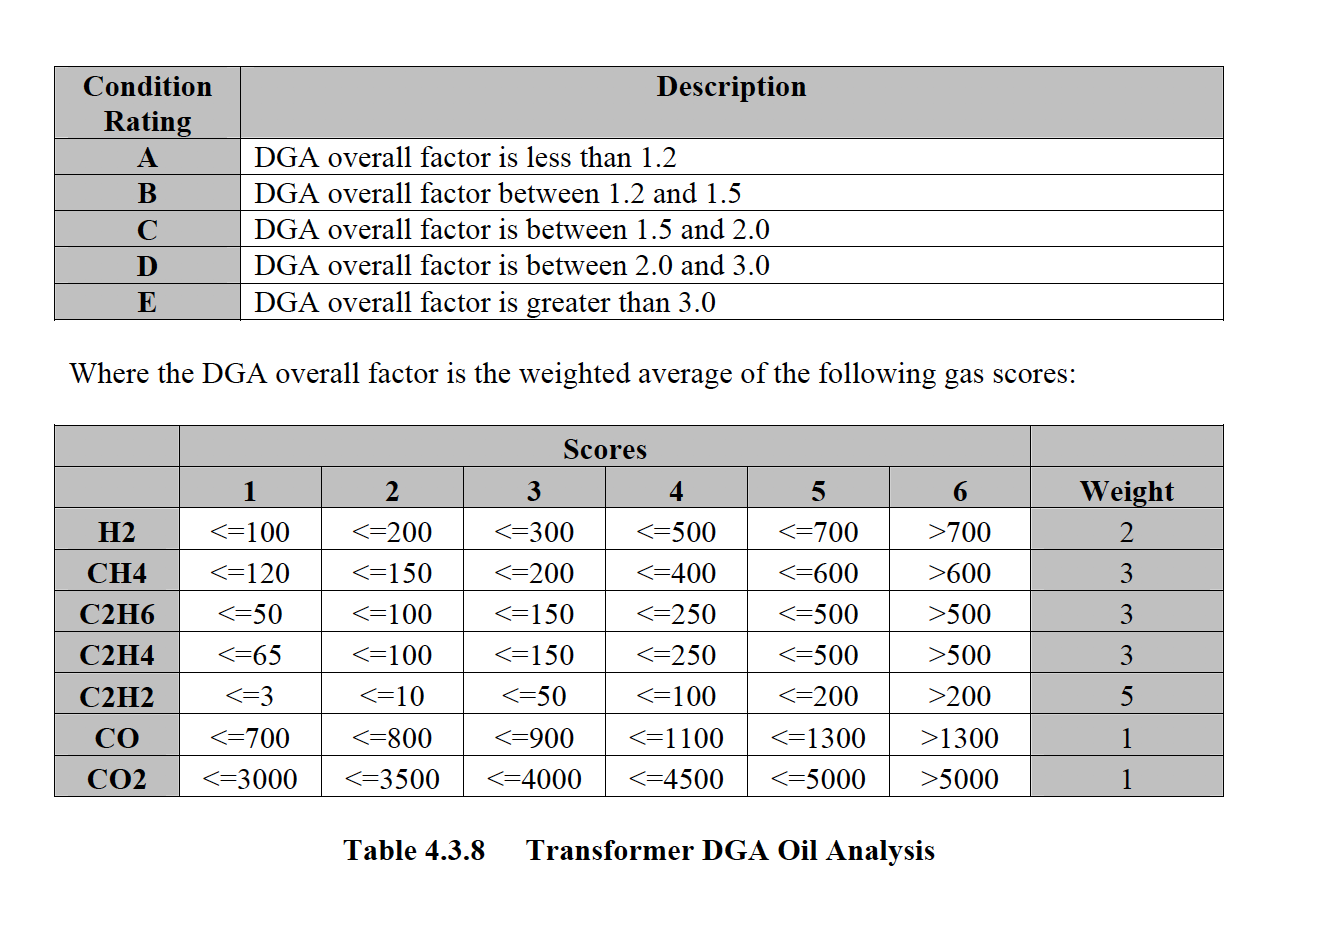
</div>


In [ ]:
@maximo_function
def calculate_dga(context, targetType=None):
    import pandas as pd
    H2_meter = context.get_parameter(name="H2 meter")# id 
    H2 = float(context.get_meter_last_reading(H2_meter,target=targetType).replace(',',''))
    CH4_meter = context.get_parameter(name="CH4 meter")
    CH4 = float(context.get_meter_last_reading(CH4_meter,target=targetType).replace(',',''))
    C2H6_meter = context.get_parameter(name="C2H6 meter")
    C2H6 = float(context.get_meter_last_reading(C2H6_meter,target=targetType).replace(',',''))
    C2H4_meter = context.get_parameter(name="C2H4 meter")
    C2H4 = float(context.get_meter_last_reading(C2H4_meter,target=targetType).replace(',',''))
    C2H2_meter = context.get_parameter(name="C2H2 meter")
    C2H2 = float(context.get_meter_last_reading(C2H2_meter,target=targetType).replace(',',''))
    CO_meter = context.get_parameter(name="CO meter")
    CO = float(context.get_meter_last_reading(CO_meter,target=targetType).replace(',',''))
    CO2_meter = context.get_parameter(name="CO2 meter")
    CO2 = float(context.get_meter_last_reading(CO2_meter,target=targetType).replace(',',''))
    
        
    # Based on algorithm description

    H2_score = 1 if H2 <= 100 else (2 if H2 > 100 and H2 <= 200 else (3 if H2 > 200 and H2 <= 300 else (
        4 if H2 > 300 and H2 <= 500 else (5 if H2 > 500 and H2 <= 700 else 6))))
    CH4_score = 1 if CH4 <= 120 else (2 if CH4 > 120 and CH4 <= 150 else (3 if CH4 > 150 and CH4 <= 200 else (
        4 if CH4 > 200 and CH4 <= 400 else (5 if CH4 > 400 and CH4 <= 600 else 6))))
    C2H6_score = 1 if C2H6 <= 50 else (2 if C2H6 > 50 and C2H6 <= 100 else (3 if C2H6 > 100 and C2H6 <= 150 else (
        4 if C2H6 > 150 and C2H6 <= 250 else (5 if C2H6 > 250 and C2H6 <= 500 else 6))))
    C2H4_score = 1 if C2H4 <= 65 else (2 if C2H4 > 65 and C2H4 <= 100 else (3 if C2H4 > 100 and C2H4 <= 150 else (
        4 if C2H4 > 150 and C2H4 <= 250 else (5 if C2H4 > 250 and C2H4 <= 500 else 6))))
    C2H2_score = 1 if C2H2 <= 3 else (2 if C2H2 > 3 and C2H2 <= 10 else (3 if C2H2 > 10 and C2H2 <= 50 else (
        4 if C2H2 > 50 and C2H2 <= 100 else (5 if C2H2 > 100 and C2H2 <= 200 else 6))))
    CO_score = 1 if CO <= 700 else (2 if CO > 700 and CO <= 800 else (3 if CO > 800 and CO <= 900 else (
        4 if CO > 900 and CO <= 1100 else (5 if CO > 1100 and CO <= 1300 else 6))))
    CO2_score = 1 if CO2 <= 3000 else (2 if CO2 > 3000 and CO2 <= 3500 else (3 if CO2 > 3500 and CO2 <= 4000 else (
        4 if CO2 > 4000 and CO2 <= 4500 else (5 if CO2 > 4500 and CO2 <= 5000 else 6))))

    overall_factor = (H2_score * 2 + CH4_score * 3 + C2H6_score * 3 + C2H4_score * 3 +
                      C2H2_score * 5 + CO_score * 1 + CO_score * 1) / (2 + 3 + 3 + 3 + 5 + 1 + 1) 
    score = 4 if overall_factor < 1.2 else (3 if overall_factor >= 1.2 and overall_factor < 1.5 else (
        2 if overall_factor >= 1.5 and overall_factor < 2.0 else(1 if overall_factor >= 2.0 and overall_factor < 3.0 else 0)))
    
    score_list=[]
    if context.is_asset() and context.is_futureScore_enabled():
        futurescore_numOfyear = context.get_futurescore_numOfyear()
        for i in range(futurescore_numOfyear):
            score_list.append(score)
    else:
        score_list.append(score)
    
    return pd.Series(score_list)

- In 8.9 the future score only supports Asset.
- Use the following function to replace the default common_calculate_condition_by_meter function to read the forecasted meter reading.
    -  Register a new function common_calculate_condition_by_meter to read the future meter reading.
        -  The function could be modified to use various data source as csv file or data frame.
        - The future meter reading must have the same shape:
            - The 1st value is the current meter reading
            - The current time interval for meter reading is by year
            - The 2nd, 3rd value is the current + 1 and current + 2 year.
        - The future meter reading value has been pre processed by customer data scientist to ensure they are in the same shape. Any missed value has been filled up by Data scentist.
        - The return value of the function must be a Pandas Series. The 1st of the returned value is the current value. And the 2nd, 3rd of the returned value is for current + 1 and current + 2 year.

In [ ]:
@healthlib.maximo_function 
def common_calculate_future_condition_by_meter(context,target=None):
    import pandas as pd
    import sys, traceback
    ##The future meter reading must have same future length. The data has been processed.
    future_meterreading_dict={ "ST_1393137":
        {
            "B-CONDIT":['A', 'B', 'C', 'D', 'E'],
            "OIL-LEAKS":['B','C','D','E','A'],
            "MAIN-TCC":['C','D','E','A','B'],
            "CO-PRES":['D','E','A','B','C'],
            "RC-SYS":['E','A','B','C','D'],
            "FS-SG":['A','A','B','B','C'],
            "OVER-PT":['C','C','D','D','E'],
            "WINDDT":['A', 'B', 'C', 'D', 'E'],
            "OIL-QT":['B','C','D','E','A'],
            "ST-THERM":['C','D','E','A','B'],
            "B-DGAOA":['A','E','A','E','A'],
            "FUR-OA":['E','A','B','C','D'],
            "TANK-CON":['A', 'B', 'C', 'D', 'E'],
            "TANK-L":['B','C','D','E','A'],
            "GS-PR":['C','D','E','A','B'],
            "LTC-CMC":['D','E','A','B','C'],
            "CTRMEC-CO":['E','A','B','C','D'],
            "OVER-TCC":['A','A','B','B','C'],
            "TC-OQT":['A','E','A','E','A'],
            "TC-QT":['A','A','B','C','E'],
            "WEAR":[1,2,3,4,5]
        },
        "ST_1393138":
        {
            "B-CONDIT":['B', 'B', 'C', 'D', 'E'],
            "OIL-LEAKS":['C','C','D','E','A'],
            "MAIN-TCC":['D','D','E','A','B'],
            "CO-PRES":['E','E','A','B','C'],
            "RC-SYS":['A','A','B','C','D'],
            "FS-SG":['B','A','B','B','C'],
            "OVER-PT":['C','C','D','D','E'],
            "WINDDT":['A', 'B', 'C', 'D', 'E'],
            "OIL-QT":['B','C','D','E','A'],
            "ST-THERM":['C','D','E','A','B'],
            "B-DGAOA":['A','E','A','E','A'],
            "FUR-OA":['E','A','B','C','D'],
            "TANK-CON":['A', 'B', 'C', 'D', 'E'],
            "TANK-L":['B','C','D','E','A'],
            "GS-PR":['C','D','E','A','B'],
            "LTC-CMC":['D','E','A','B','C'],
            "CTRMEC-CO":['E','A','B','C','D'],
            "OVER-TCC":['A','A','B','B','C'],
            "TC-OQT":['A','E','A','E','A'],
            "TC-QT":['A','A','B','C','E'],
        }
    }
    ##Check the shape of future meter reading. If the shape is inconsistent, error will be raised.
    ##Data scientist need revise the future meter reading data to make sure the shape is consistent.
    for assetnum,meters in future_meterreading_dict.items():
        future_meter_reading_shape=set()
        for key,val in meters.items():
            future_meter_reading_shape.add(len(val))

        if len(future_meter_reading_shape) > 1:
            try:
                raise RuntimeError("The future meter reading shape is inconsistent for asset :", assetnum)
            except:
                traceback.print_exc()
                sys.exit()
            

    meter_name = context.get_parameter('meter')
    assetnum =  context.get_prop('assetnum')
    if future_meterreading_dict.get(assetnum,None) is not None:
        future_condition = future_meterreading_dict[assetnum].get(meter_name,None)
        if future_condition is not None:
            table = context.get_table('condition')
            future_row =[]
            future_score = []
            for each_condition in future_condition:
                row = table.loc[table['condition'] == each_condition]
                if row.empty:
                    raise Exception(meter_name)
                future_row.append(row)

            try:
                for r in future_row:
                    score = float(r['score'].iloc[0])
                    future_score.append(score)
                return pd.Series(future_score)
            except Exception as e:
                raise Exception(e)
    else:
        raise Exception("The asset {} meter reading is not found".format(assetnum))

- In 8.9, the future score only supports Asset.
- Use the following sample function to generate the current + future health score.
- The input data source could be
    - A CSV file which contains the asset num and score list.
    - Predict function which will return a future score Time Series.
    - A python dictionary which includes the assetnum and its score.
- The output of the function is
    - A pandas series, which includes the current + future health score.

- This is a sample function to calculate the current health score based on current meter reading.

In [ ]:
def convert_dtype_to_num(obj):
    import numpy as np
    if isinstance(obj,str):
        obj_num = eval(obj)
    else:
        obj_num = obj
    if isinstance(obj_num, np.integer) or isinstance(obj_num, int):
        return int(obj_num)
    if isinstance(obj_num, np.floating) or isinstance(obj_num, float):
        return float(obj_num)

In [ ]:
def calc_cur_healthscore(context):
    from decimal import Decimal
    import pandas as pd
    contributors = context.get_contributors()
    max_length = 1
    for contributor in contributors:
        if isinstance(contributor['value'],list):
            max_length = max(max_length,len(contributor.get('value')))
        elif isinstance(contributor['value'],pd.Series):
            max_length = max(max_length,contributor['value'].size)
    value = 0
    weight = 0
    for c in contributors:
        c_weight = float(c.get('weight', 0))
        c_value_list=[]
        c_value = c.get('value', None)
        if c_value is None or c_weight is None:
            continue
        if isinstance(c_value,list):
            c_value_series = pd.Series(c_value)
        elif isinstance(c_value, pd.Series):
            c_value_series =  c_value
        else:
            for i in range(max_length):
                c_value_list.append(c_value)
            c_value_series = pd.Series(c_value_list)
        weight = weight + c_weight
        cur_value = convert_dtype_to_num(c_value_series.iloc[0])
        value = value + c_weight * cur_value
        
    if weight == 0:
        raise RuntimeError('No contributor to calculate')

    weighted_value = Decimal(value / weight).quantize(Decimal("0.00"), rounding = "ROUND_HALF_UP")
    return float(weighted_value)

### Get future health score from csv file
- This is a sample function to read the health future score from csv file.
- The csv file could be uploaded to the data asset of the project.
- Here is a sample csv file format.

|assetnum|year|health|
|---------|------|--------|
|ST_1393137 |2023 | 95 |
|ST_1393137 |2024 | 86 |
|ST_1393137 |2025 | 77 |
|ST_1393137 |2026 | 66 |
|ST_1393137 |2027 | 60 |
|ST_1393138 |2023 | 53 |
|ST_1393138 |2024 | 49 |
|ST_1393138 |2025 | 45 |
|ST_1393138 |2026 | 33 |
|ST_1393138 |2027 | 24 |
|ST_1393138 |2028 | 18 |

In [ ]:
# import pandas as pd
# from pathlib import Path 
# df = pd.DataFrame({'assetnum': ['TEST_ST_214902','TEST_ST_214902','TEST_ST_214902','TEST_ST_214902','TEST_ST_214902','TEST_ST_214901','TEST_ST_214901','TEST_ST_214901','TEST_ST_214901','TEST_ST_214901'],
#            'year': ['2023','2024','2025','2026','2027','2023','2024','2025','2026','2027'],
#            'health': ['50','40','30','20','10','50','40','30','20','10']})
# # print(df)

# filepath = Path('/tmp/assets_future_score.csv')
# df.to_csv(filepath,index=False)

# !cat /tmp/assets_future_score.csv

# from ibm_watson_studio_lib import access_project_or_space
# wslib = access_project_or_space()
# file_name = "assets_future_score.csv"
# file_path = "/tmp/" + file_name
# with open(file_path, 'rb') as f:
#     wslib.save_data(asset_name_or_item=file_name, data=f.read(), overwrite=True)
    
# !rm -f /tmp/assets_future_score.csv

In [ ]:
def get_health_future_score_from_csv(csv_file_name):
    import pandas as pd
    from pathlib import Path
    #from ibm_watson_studio_lib import access_project_or_space

    future_health_score_dict={}

    #Specify the csv file path
    csv_path = Path("/project_data/data_asset")

    #current_working_ws_project = access_project_or_space()
    
    #Specify the csv file name
    file = str(csv_path) + "/" + csv_file_name

    #buffer = current_working_ws_project.load_data(file)
    #buffer.seek(0)

    #all_assets_future_score_df = pd.read_csv(buffer)
    all_assets_future_score_df = pd.read_csv(file)

    time_column = "year"
    health_score_column = "health"
    asset_id_column = "assetnum"

    grouped_df = all_assets_future_score_df.groupby(asset_id_column)    

    for sub_group in [grouped_df.get_group(x) for x in grouped_df.groups]:
        sub_group_sorted = sub_group.sort_values(by=[time_column],ascending=True)
        key = sub_group_sorted[asset_id_column].iloc[0]
        val = sub_group_sorted[health_score_column].tolist()
        future_health_score_dict[key]=val

    return future_health_score_dict


- Here is a sample function to calculate both current health score and future health score.
    - The current health score is from the current meter reading.
    - The future health score is from WML prediction or input directly.
- The current health score will combine with future health score together and save back to health.

In [ ]:
@healthlib.maximo_function 
def calculate_health_score(context,target=None):
    import pandas as pd
    ##The future health score input can be any data source.
    #1. Read the future score from the predicted Health score.
    #2. Read the future score from an csv file
    #3. Read the future score from the input
    #The output of the function is a Series. 
    #The 1st score is the current score.
    #The 2nd score is current + 1 year score.
    #The 3rd score is current + 2 years score.
    
    cur_health_score = None 
    try:
        cur_health_score = calc_cur_healthscore(context)
    except Exception: 
        raise Exception
    #Sample of future health score direct input.
    future_health_score_dict={
         "ST_1393137":[52, 51, 40, 49, 44, 41, 50, 33, 48, 45],
         "ST_1393138":[40, 55, 54, 37, 55, 45, 53, 33, 44, 47],
         "ST_1400501":[44, 55, 44, 41, 50, 35, 34, 33, 44, 42],
         "ST_1400502":[56, 50, 40, 45, 48, 39, 50, 43, 32, 43],
         "ST_1400517":[46, 51, 46, 48, 38, 37, 38, 35, 46, 42],
         "ST_1400518":[44, 47, 42, 56, 55, 47, 42, 37, 32, 47],
         "ST_1400519":[50, 58, 42, 45, 47, 41, 34, 47, 32, 35],
         "ST_5014":[44, 45, 54, 53, 44, 41, 44, 37, 42, 31],
         "ST_5027":[48, 58, 54, 47, 50, 46, 38, 37, 46, 41],
         "ST_5028":[52, 58, 54, 48, 44, 49, 42, 45, 43, 50]
     }
    if context.is_futureScore_enabled():

        ##Sample of to get future health score from csv file
        ##Specify the csv file name.
        #csv_file_name = "st_assets_future_score.csv"
        #future_health_score_dict = get_health_future_score_from_csv(csv_file_name)
        
        if context.is_asset:
            key = context.get_prop('assetnum')
        elif context.is_location:
            key = context.get_prop('location')
            
        #new_key = key + ".csv"
        new_key = key
        if cur_health_score is not None:
            if future_health_score_dict.get(new_key,None) is not None:
                future_score_series = pd.Series(future_health_score_dict[new_key])
                future_score_series.index = future_score_series.index + 1
                cur_future_score_series = pd.concat([pd.Series([cur_health_score]), future_score_series])   
                return cur_future_score_series
            else:
                return pd.Series([cur_health_score])
        else:
            raise RuntimeError('The current health score is not available for asset {}'.format(key))
    else:
        return pd.Series([cur_health_score])

### Register functions for NOC
- NOC, short for number of customer is a contributor for Criticality calculation.
    - Register a new function `calculate_number_of_customer_before` to run before each assets batch.
        - `healthlib._FEEDER_DATA` is a global varaible used to store FEEDER Data.
        - `healthlib.query_health` is a function used to query data from health, in this case, get FEEDER data.
            - `oslc.select`,`oslc.where`,`locations.locationsspecclass.where` is the supported parameters in health MXAPIOPERLOC api.
        - Register a new function `calculate_number_of_customer` for each asset's Criticality calculation.

In [ ]:
def get_number_of_customer(siteid):
    feeders = healthlib.query_maximo(api='MXAPIOPERLOC', params={
            'oslc.select':'siteid,location,locationspec{assetattrid,numvalue}',
            'oslc.where':'classstructure.classificationid="FEEDER" and siteid="{}"'.format(siteid),
            'oslc.orderBy': '+location,+siteid',
            'locations.locationsspecclass.where':'assetattrid="NUMBEROFCUSTOMERS"',
            'lean': 1})
    
    return feeders

In [ ]:
siteid_set=set()
feeder_dict={}
@healthlib.maximo_function
def calculate_number_of_customer(context,targetType=None):    
    
    siteid = context.get_prop('siteid')
    logger = healthlib.get_logger()
    noc_attr = context.get_parameter(name='NOC attribute')
    logger.debug('Noc attribute=%s', noc_attr)

    noc = context.get_spec(noc_attr)
    logger.debug('noc=%s', noc)

    feeder_attr = context.get_parameter(name='Feeder attribute')

    logger.debug('Feeder attribute=%s', feeder_attr)

    feeder = context.get_spec(feeder_attr)

    logger.debug('feeder=%s', feeder)

    feeder_noc = None
    #feeders = context.get_shared_data('feeders')
    if siteid not in siteid_set:
        siteid_set.add(siteid)
        feeders = get_number_of_customer(siteid)
        feeder_dict[siteid] = feeders
    else:
        feeders = feeder_dict[siteid]
    if feeders is None:
        raise healthlib.errors.InputDataError('Can not find feeder NOC')

    logger.debug('got feeders')
    for f in feeders:
        if f['location'] == feeder.upper():
            for s in f['locationspec']:
                if s['assetattrid'] == "NUMBEROFCUSTOMERS":
                    feeder_noc = s['numvalue']
                    break
            break
    logger.debug('feeder noc=%s', feeder_noc)
    if feeder_noc == None:
        raise healthlib.errors.InputDataError('Can not find feeder NOC')
    if feeder_noc <= noc:
        return 100 #TODO
        raise healthlib.errors.InputDataError('feeder noc {} <= noc {}'.format(feeder_noc, noc))
    result = min(100,max(0, 100 * noc/feeder_noc))
    return result

## Step 5. Run score calculation

- Set logger level from: DEBUG, INFO, WARNING, ERROR and CRITICALITY. Default level is WARNING.

In [ ]:
healthlib.set_log_level(level='INFO')

- just call `healthlib.run()` method to do the analysis. Internally, `healthlib.run()` method will save the analysis result back to Maximo Health.

In [ ]:
healthlib.run()

## (Optional) Step 6. Test functions
- healthlib also provides some function to do quick local test for data scientist, with the model configurations above
- input variables:
    - `maximoUrl`: the Maximo environment endpoint
    - `mx_user`: the maximo user
    - `mx_pwd`: the maximo password
    - `grouopname`: the asset/location group name
    - `apmownerid`: the target single asset/location
    - `components`: pre-define some components to do the test, if have

In [ ]:
test_maximoUrl="*"
test_mx_user="*"
test_mx_pwd="*"
test_apikey = '*'
site=""

Bushing condition --> common_calculate_condition_by_meter

In [ ]:
healthlib.local_test(
    maximoUrl=test_maximoUrl,
    maximoApiKey=test_apikey,
    siteid=site,
    assetnum='',
    components=[
        {
            'name':'Bushing Condition',
            'parameters': [
                {
                    'name': 'Condition meter',
                    'value': 'B-CONDIT'
                }
            ],
            'contributors': []
        }
    ]
)

Age --> common_calculate_age

In [ ]:
healthlib.local_test(
    maximoUrl=test_maximoUrl,
    maximoApiKey=test_apikey,
    siteid=site,
    assetnum='',
    components=[
            {
            'name':'Age',
            'parameters': [],
            'contributors': []
        }
        
    ]
)

DGA

In [ ]:
healthlib.local_test(
    maximoUrl=test_maximoUrl,
    maximoApiKey=test_apikey,
    siteid=site,
    assetnum='',
    components=[
        {
            'name':'DGA Oil Analysis',
            'parameters':[
                {
                    'name': 'H2 meter',
                    'value': 'DGAR-H2'
                }, 
                {
                    'name': 'CH4 meter',
                    'value': 'DGAR-CH4'
                }, 
                {
                    'name': 'C2H6 meter',
                    'value': 'DGAR-C2H6'
                }, 
                {
                    'name': 'C2H4 meter',
                    'value': 'DGAR-C2H4'
                }, 
                {
                    'name': 'C2H2 meter',
                    'value': 'DGAR-C2H2'
                }, 
                {
                    'name': 'CO meter',
                    'value': 'DGAR-CO'
                }, 
                {
                    'name': 'CO2 meter',
                    'value': 'DGAR-CO'
                }
            ],
            'contributors': []
        }
    ]
)

In [ ]:
healthlib.local_test(
   maximoUrl=test_maximoUrl,
     maximoApiKey=test_apikey,
    siteid=site,
    assetnum='',
    components=[
        {
            'name':'Group',
            'contributors': [
                {
                  'name': "Bushing Condition",
                  'role': '',
                  'weight': 3,
                  'value': 2
              },
              {
                  'name': "Oil Leaks",
                  'role': 'factor',
                  'weight': 3,
                  'value': 1
              }, {
                  'name': "Main Tank/Cabinets and Control Condition",
                  'role': '',
                  'weight': 3,
                  'value': 3
              }, {
                  'name': "Conservator/Oil Preservation System Condition",
                  'role': '',
                  'weight': 3,
                  'value': 3
              }, {
                  'name': "Radiators/Cooling System Condition",
                  'role': '',
                  'weight': 3,
                  'value': 3
              }, {
                  'name': "Foundation/Support Steel/Grounding Condition",
                  'role': '',
                  'weight': 3,
                  'value': 3
              }, {
                  'name': "Overall Power Transformer Condition",
                  'role': '',
                  'weight': 8,
                  'value': 3
              }, {
                  'name': "Winding Doble Test",
                  'role': '',
                  'weight': 14,
                  'value': 3
              }, {
                  'name': "Oil Quality Test",
                  'role': '',
                  'weight': 10,
                  'value': 3
              }, {
                  'name': "Thermograph (IR)",
                  'role': '',
                  'weight': 8,
                  'value': 3
              }, {
                  'name': "Bushing DGA Analysis",
                  'role': '',
                  'weight': 14,
                  'value': 3
              }, {
                  'name': "Furan Oil Analysis",
                  'role': '',
                  'weight': 14,
                  'value': 3
              }, {
                  'name': "DGA Oil Analysis",
                  'role': '',
                  'weight': 14,
                  'value': 3
              }
          ]
    }
    ]
)

Effective Age --> common_calculate_effective_age

In [ ]:
healthlib.local_test(
    maximoUrl=test_maximoUrl,
     maximoApiKey=test_apikey,
    siteid=site,
    assetnum='',                
    components=[{'name': "Effective Age",
              'parameters': [
                  {
                      'name': 'Mean life',
                      'value': '30'
                  }
               ],
              'contributors': [
                  {
                                  'name': "Health",
                                  'role': 'HEALTH',
                                  'value': 20
                              },
                              {
                                  'name': "Age",
                                  'role': 'AGE',
                                  'value': 1
                              }]
              }])

Criticality --> common_calculate_weighted

In [ ]:
healthlib.local_test(
    maximoUrl=test_maximoUrl,
     maximoApiKey=test_apikey,
    siteid=site,
    assetnum='', 
    components=[{'name': "Criticality",
              'parameters': [],
              'contributors': [{
                                  'name': "Number of Customer",
                                  'role': '',
                                  'value': 100,
                                'weight':100
                              }]
              }])

End of Life --> common_calculate_end_of_life 

In [ ]:
healthlib.local_test(
    maximoUrl=test_maximoUrl,
     maximoApiKey=test_apikey,
    siteid=site,
    assetnum='', 
    components=[{'name': "End of Life",
              'parameters': [],
              'contributors': [{
                                  'name': "Effective Age",
                                  'role': 'EFFECTIVEAGE',
                                  'value': 20
                              }]
              }])

Risk --> common_calculate_risk

In [ ]:
healthlib.local_test(
    maximoUrl=test_maximoUrl,
     maximoApiKey=test_apikey,
    siteid=site,
    assetnum='',   
    components=[{'name': "Risk",
              'parameters': [],
              'contributors': [{
                                  'name': "Criticality",
                                  'role': 'CRITICALITY',
                                  'value': 20
                              },
                              {
                                  'name': "End of Life",
                                  'role': 'EOL',
                                  'value': 15
                              }]
              }])